After previously developing some still image visualisations, I'm now going to use the Open CV 'VideoWriter' class to output an animation of the visualisation.

In [1]:
# Import relevant libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [2]:
frame = np.zeros((16,32,3),dtype=np.uint8) # initialise a frame

srate,data = wavfile.read('Cascada - Everytime We Touch (Official Video).wav') # Load audio

/tmp/ipykernel_10560/353790320.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  srate,data = wavfile.read('Cascada - Everytime We Touch (Official Video).wav') # Load audio


**Review of Still Images**

To prepare for animation, let's first re-tread some stuff from Still_Image_Tests.

/tmp/ipykernel_10560/341744151.py:6: RuntimeWarning: overflow encountered in scalar negative
  self.data_norm = self.data/(max(np.amax(self.data), -np.amin(self.data)))
/tmp/ipykernel_10560/341744151.py:30: RuntimeWarning: divide by zero encountered in log10
  freq_plot = 10*np.log10(np.abs(plotter.freqSignal()))


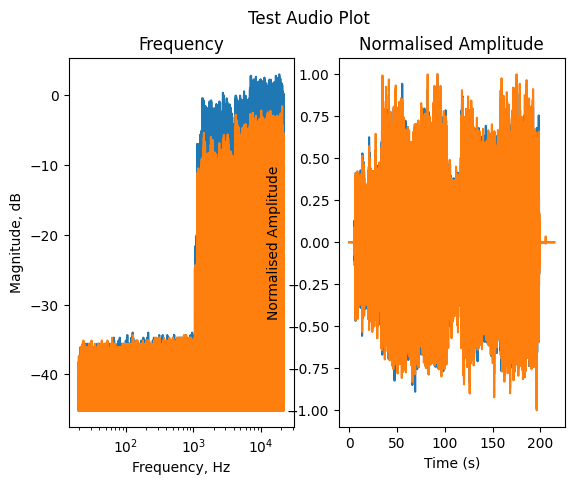

In [3]:
class SignalPlotter:
    def __init__(self,srate,data):
        self.srate, self.data = srate,data
        self.duration = len(self.data)/self.srate
        self.t = np.arange(0, self.duration,1/self.srate)
        self.data_norm = self.data/(max(np.amax(self.data), -np.amin(self.data)))

    def rawSignal(self):
        '''Returns an array for the raw signal'''
        return self.data

    def normSignal(self):
        '''Returns an array for the normalised signal'''
        return self.data_norm

    def freqSignal(self):
        '''Performs fft on normalised signal and returns array'''
        data_norm_f = np.fft.fft(self.data_norm)
        data_norm_f = data_norm_f[:len(data_norm_f)//2]
        return data_norm_f

plotter = SignalPlotter(srate,data)

x_plotter = np.linspace(20, plotter.srate/2, len(plotter.freqSignal()))



fig3, (ax1, ax2) = plt.subplots(1,2)
fig3.suptitle("Test Audio Plot")
freq_plot = 10*np.log10(np.abs(plotter.freqSignal()))
ax1.plot(x_plotter, freq_plot)
ax2.plot(plotter.t, plotter.normSignal())

ax1.set_xscale('log')
# ax2.set_xscale('log')
ax1.set_xlabel("Frequency, Hz")
ax1.set_ylabel("Magnitude, dB")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Normalised Amplitude")
ax1.set_title("Frequency")
ax2.set_title("Normalised Amplitude")
plt.show()

In [4]:
print(len(data[:,0]))

9463808


In [5]:
freq_spectrum = np.abs(plotter.freqSignal())[:,0]
length = len(freq_spectrum)
bins = np.linspace(0,length,33)

colour_spectrum = freq_spectrum*(255/np.amax(freq_spectrum))
colour_bins = np.linspace(0,length,4)

print('freq_spectrum:',freq_spectrum)
print('length:',length)
print('bins:',bins)

print('colour_spectrum:', colour_spectrum)
print('colour_bins:', colour_bins)

freq_spectrum: [0.         0.         0.         ... 0.46836756 0.43327128 0.36515397]
length: 4731904
bins: [      0.  147872.  295744.  443616.  591488.  739360.  887232. 1035104.
 1182976. 1330848. 1478720. 1626592. 1774464. 1922336. 2070208. 2218080.
 2365952. 2513824. 2661696. 2809568. 2957440. 3105312. 3253184. 3401056.
 3548928. 3696800. 3844672. 3992544. 4140416. 4288288. 4436160. 4584032.
 4731904.]
colour_spectrum: [ 0.          0.          0.         ... 59.71686453 55.24208808
 46.55713065]
colour_bins: [      0.         1577301.33333333 3154602.66666667 4731904.        ]


<function matplotlib.pyplot.show(close=None, block=None)>

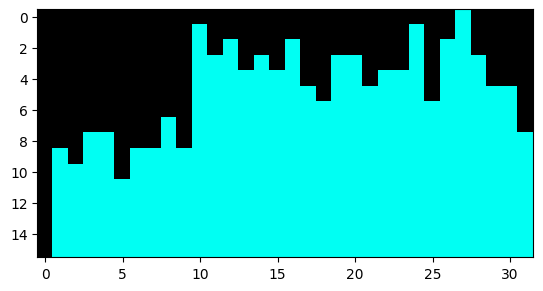

In [6]:
mask = np.zeros((16,32,3),dtype=np.uint8)

mask_spectrum = freq_spectrum*(16/np.amax(freq_spectrum)) # scale the y-axis to range between 0 and 16

for i in range(len(bins)-1):
    bin = np.amax(mask_spectrum[int(bins[i]):int(bins[i+1])])
    mask[16-int(bin):,i,:] = 255
    
frame = np.zeros((16,32,3),dtype=np.uint8)

colour_spectrum = freq_spectrum*(255/np.amax(freq_spectrum))

colour_bins = np.linspace(0,length,3)

for i in range(len(colour_bins)-1):
    bin = np.amax(colour_spectrum[int(colour_bins[i]):int(colour_bins[i+1])])
    frame[:,:,i] = int(bin)

frame[mask==0] = 0

plt.imshow(cv.cvtColor(frame,cv.COLOR_BGR2RGB))
plt.show

**Building the Animation Method**

Now let's start animating this.

First, let's get some helpful constants

In [7]:
Fs_audio = srate
Fs_video  = 30

out_path = "Test_out.mp4"

n_frame = Fs_audio//Fs_video # Number of audio samples per frame

n_frames = len(data)//n_frame

print(n_frame)


1470


Now, let's check that I can get 'buffers' of the right sie from my audio data

In [8]:
for i in range(2):
    ptr = i*(n_frame)
    buffer = data[ptr:ptr+n_frame,0]
    print(len(buffer))
    

1470
1470


Now let's try creating FFT plots for the first two audio buffers

/tmp/ipykernel_10560/205120630.py:11: RuntimeWarning: divide by zero encountered in log10
  freq_plot = 10*np.log10(np.abs(plotter.freqSignal()))


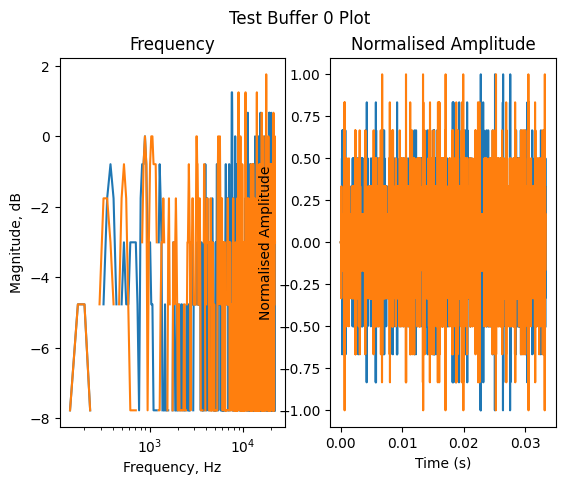

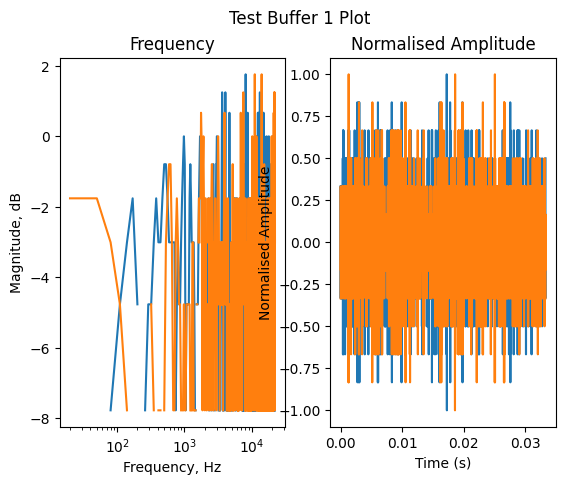

In [9]:
for i in range(2):
    ptr = i*(n_frame)
    buffer = data[ptr:ptr+n_frame,:]

    plotter = SignalPlotter(Fs_audio,buffer)

    x_plotter = np.linspace(20, plotter.srate/2, len(plotter.freqSignal()))

    fig3, (ax1, ax2) = plt.subplots(1,2)
    fig3.suptitle("Test Buffer "+str(i)+" Plot")
    freq_plot = 10*np.log10(np.abs(plotter.freqSignal()))
    ax1.plot(x_plotter, freq_plot)
    ax2.plot(plotter.t, plotter.normSignal())

    ax1.set_xscale('log')
    # ax2.set_xscale('log')
    ax1.set_xlabel("Frequency, Hz")
    ax1.set_ylabel("Magnitude, dB")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Normalised Amplitude")
    ax1.set_title("Frequency")
    ax2.set_title("Normalised Amplitude")
    plt.show()
    
    

Good news: The FFT does work with this small a buffer

Bad news: It probably won't look very good

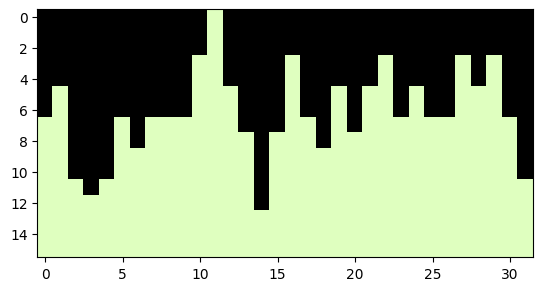

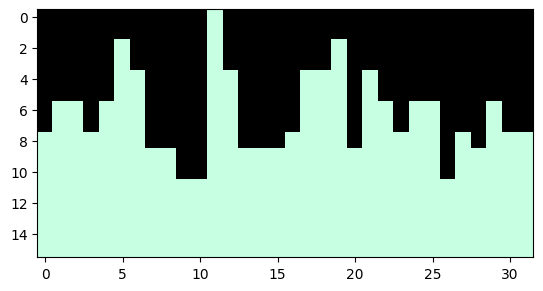

In [10]:
for i in range(2):
    ptr = i*(n_frame)
    buffer = data[ptr:ptr+n_frame,:]

    plotter = SignalPlotter(Fs_audio,buffer)

    freq_spectrum = np.abs(plotter.freqSignal())[:,0]
    length = len(freq_spectrum)

    bins = np.linspace(0,length,33)
    colour_bins = np.linspace(0,length,4)

    colour_spectrum = freq_spectrum*(255/np.amax(freq_spectrum))
    mask_spectrum = freq_spectrum*(16/np.amax(freq_spectrum)) # scale the y-axis to range between 0 and 16

    mask = np.zeros((16,32,3),dtype=np.uint8)
    frame = np.zeros((16,32,3),dtype=np.uint8)

    for j in range(len(bins)-1):
        bin = np.amax(mask_spectrum[int(bins[j]):int(bins[j+1])])
        mask[16-int(bin):,j,:] = 255

    

    for i in range(len(colour_bins)-1):
        bin = np.amax(colour_spectrum[int(colour_bins[i]):int(colour_bins[i+1])])
        frame[:,:,i] = int(bin)

    frame[mask==0] = 0

    plt.figure()
    plt.imshow(cv.cvtColor(frame,cv.COLOR_BGR2RGB))
    plt.show

    

Now that I can show the represenations of The low-res FFTs change with each buffer (and they do look okay) I can start actaully animating.

In [14]:
out = cv.VideoWriter(out_path,cv.VideoWriter.fourcc(*'mp4v'),Fs_video,(32,16))

for i in range(n_frames):
    ptr = i*(n_frame)
    buffer = data[ptr:ptr+n_frame,:]

    plotter = SignalPlotter(Fs_audio,buffer)

    freq_spectrum = np.abs(plotter.freqSignal())[:,0]
    length = len(freq_spectrum)

    bins = np.linspace(0,length,33)
    colour_bins = np.linspace(0,length,4)

    colour_spectrum = freq_spectrum*(255/np.amax(freq_spectrum))
    mask_spectrum = freq_spectrum*(16/np.amax(freq_spectrum)) # scale the y-axis to range between 0 and 16

    mask = np.zeros((16,32,3),dtype=np.uint8)
    frame = np.zeros((16,32,3),dtype=np.uint8)

    for j in range(len(bins)-1):
        bin = np.amax(mask_spectrum[int(bins[j]):int(bins[j+1])])
        mask[16-int(bin):,j,:] = 255

    

    for i in range(len(colour_bins)-1):
        bin = np.amax(colour_spectrum[int(colour_bins[i]):int(colour_bins[i+1])])
        frame[:,:,i] = int(bin)

    frame[mask==0] = 0

    out.write(frame)

out.release()
cv.destroyAllWindows()

    

/tmp/ipykernel_10560/341744151.py:6: RuntimeWarning: overflow encountered in scalar negative
  self.data_norm = self.data/(max(np.amax(self.data), -np.amin(self.data)))


Well that looks a bit mad

Let's see if a lower frame-rate makes it a bit less mad

In [12]:
Fs_video = 12
n_frame = Fs_audio//Fs_video # Number of audio samples per frame
n_frames = len(data)//n_frame

out = cv.VideoWriter("12fps.mp4",cv.VideoWriter.fourcc(*'mp4v'),Fs_video,(32,16))

for i in range(n_frames):
    ptr = i*(n_frame)
    buffer = data[ptr:ptr+n_frame,:]

    plotter = SignalPlotter(Fs_audio,buffer)

    freq_spectrum = np.abs(plotter.freqSignal())[:,0]
    length = len(freq_spectrum)

    bins = np.linspace(0,length,33)
    colour_bins = np.linspace(0,length,4)

    colour_spectrum = freq_spectrum*(255/np.amax(freq_spectrum))
    mask_spectrum = freq_spectrum*(16/np.amax(freq_spectrum)) # scale the y-axis to range between 0 and 16

    mask = np.zeros((16,32,3),dtype=np.uint8)
    frame = np.zeros((16,32,3),dtype=np.uint8)

    for j in range(len(bins)-1):
        bin = np.amax(mask_spectrum[int(bins[j]):int(bins[j+1])])
        mask[16-int(bin):,j,:] = 255

    

    for i in range(len(colour_bins)-1):
        bin = np.amax(colour_spectrum[int(colour_bins[i]):int(colour_bins[i+1])])
        frame[:,:,i] = int(bin)

    frame[mask==0] = 0

    out.write(frame)

out.release()
cv.destroyAllWindows()

    

/tmp/ipykernel_10560/341744151.py:6: RuntimeWarning: overflow encountered in scalar negative
  self.data_norm = self.data/(max(np.amax(self.data), -np.amin(self.data)))


That hasn't helped.

*Two areas to improve:*
* Figure out what's causing the blurring - it could be an issue with the video compression.
* Have smoother transitions between frames - maybe process the FFT at 10fps, but have intermediate frames transitioning between each FFT at 30fps

# Fixing the blurring issue
*(1/3/23)*

Tom has helpfully pointed out that I need to up-sample the video explicitly by 'nearest neighbour' interpolation to avoid OpenCV upsampling by another method automatically.

In [16]:
out = cv.VideoWriter("no_blur_test.mp4",cv.VideoWriter.fourcc(*'mp4v'),Fs_video,(320,160))

for i in range(n_frames):
    ptr = i*(n_frame)
    buffer = data[ptr:ptr+n_frame,:]

    plotter = SignalPlotter(Fs_audio,buffer)

    freq_spectrum = np.abs(plotter.freqSignal())[:,0]
    length = len(freq_spectrum)

    bins = np.linspace(0,length,33)
    colour_bins = np.linspace(0,length,4)

    colour_spectrum = freq_spectrum*(255/np.amax(freq_spectrum))
    mask_spectrum = freq_spectrum*(16/np.amax(freq_spectrum)) # scale the y-axis to range between 0 and 16

    mask = np.zeros((16,32,3),dtype=np.uint8)
    frame = np.zeros((16,32,3),dtype=np.uint8)

    for j in range(len(bins)-1):
        bin = np.amax(mask_spectrum[int(bins[j]):int(bins[j+1])])
        mask[16-int(bin):,j,:] = 255

    

    for i in range(len(colour_bins)-1):
        bin = np.amax(colour_spectrum[int(colour_bins[i]):int(colour_bins[i+1])])
        frame[:,:,i] = int(bin)

    frame[mask==0] = 0

    out.write(cv.resize(frame, (320, 160), interpolation=cv.INTER_NEAREST))

out.release()
cv.destroyAllWindows()

    

/tmp/ipykernel_10560/341744151.py:6: RuntimeWarning: overflow encountered in scalar negative
  self.data_norm = self.data/(max(np.amax(self.data), -np.amin(self.data)))


That's fixed it!